<a href="https://colab.research.google.com/github/JoelRaju403/JoelRaju403/blob/main/Telltale_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !git clone https://github.com/MPaloze/Telltale.git
# %cd Telltale
# !pip install -r requirements.txt


In [ ]:
# !pip3 uninstall -y torch torchvision torchaudio

# !pip3 install torch torchvision torchaudio \
#   --index-url https://download.pytorch.org/whl/cu118


In [ ]:
# !pip install torch-tps

In [ ]:
# # import torch
# # from torchvision import datasets, transforms


# # transform = transforms.Compose([
# #     transforms.ToTensor(),
# #     transforms.Normalize((0.5,), (0.5,))
# # ])


# # train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# # test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# # # import torch, torchvision
# # # from torchvision.ops import nms
# # # print("nms operator:", nms)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




In [ ]:
# # 1) Clone the three official backdoor-attack repos
# !git clone https://github.com/VinAIResearch/Warping-based_Backdoor_Attack-release.git
# !git clone https://github.com/yuezunli/ISSBA.git
# #!git clone https://github.com/YiZeng623/Narcissus-backdoor-attack.git


In [ ]:
# # issba_trigger.py

# import sys
# import os
# import torch
# from torchvision import transforms
# from PIL import Image

# # 1) Ensure the ISSBA repo root is on sys.path so we can import models.py
# repo_root = os.path.abspath("/content/ISSBA")                 # adjust path if needed
# if repo_root not in sys.path:
#     sys.path.insert(0, repo_root)                             # give priority to our repo :contentReference[oaicite:1]{index=1}

# # 2) Now import Encoder directly from top-level models.py
# from models import Encoder                                      # models.py is at the repo root :contentReference[oaicite:2]{index=2}

# # 3) Helper to convert inputs to PIL.Image
# #    (ensure_pil must be defined elsewhere in your notebook)
# # from your_common_utils import ensure_pil

# class ISSBATrigger:
#     def __init__(self, model_path, device='cpu'):
#         """
#         model_path: path to a pretrained ISSBA encoder .pth file
#         device: 'cpu' or 'cuda'
#         """
#         self.device = torch.device(device)
#         # Instantiate the official ISSBA Encoder and load pretrained weights
#         self.encoder = Encoder().to(self.device)
#         self.encoder.load_state_dict(
#             torch.load(model_path, map_location=self.device)
#         )
#         self.encoder.eval()                                       # disable dropout/batchnorm updates :contentReference[oaicite:3]{index=3}

#         # Prepare transforms
#         self.to_tensor = transforms.ToTensor()
#         self.to_pil    = transforms.ToPILImage()

#     def apply(self, img):
#         """
#         img: PIL.Image or torch.Tensor or numpy.ndarray
#         returns: PIL.Image with a sample-specific stego trigger applied
#         """
#         # Convert any input to PIL.Image with uint8 channels
#         pil = ensure_pil(img)                                     # squeezes, transposes, casts floats to uint8

#         # PIL.Image -> FloatTensor [0,1] -> add batch dim -> move to device
#         x = self.to_tensor(pil).unsqueeze(0).to(self.device)      # shape (1,C,H,W)

#         # Forward through the encoder to get a sample-specific perturbation
#         with torch.no_grad():
#             x_out = self.encoder(x)                               # shape (1,C,H,W)

#         # Back to PIL.Image for dataset ingestion
#         return self.to_pil(x_out.squeeze(0).cpu())


In [ ]:
# # narcissus_trigger.py
# import torch
# import numpy as np
# from torchvision import transforms
# from PIL import Image

# # Helper: ensure_pil must be available in your notebook
# # from your_common_utils import ensure_pil

# class NarcissusTrigger:
#     def __init__(self, trigger_path, device='cpu'):
#         """
#         trigger_path: path to a .npy file containing the Narcissus trigger array
#                       of shape (1,3,32,32) in [0,1]
#         device: 'cpu' or 'cuda'
#         """
#         self.device = torch.device(device)
#         # 1) Load the precomputed trigger (NumPy → Torch)
#         arr = np.load(trigger_path)                          # (1,3,32,32)
#         self.trigger = torch.from_numpy(arr).float().to(self.device)

#         # 2) Transforms
#         self.to_tensor = transforms.ToTensor()
#         self.to_pil    = transforms.ToPILImage()

#     def apply(self, img):
#         """
#         img: PIL.Image or Tensor/ndarray
#         returns: PIL.Image with clean-label Narcissus trigger added
#         """
#         pil = ensure_pil(img)
#         x = self.to_tensor(pil).unsqueeze(0).to(self.device)  # (1,C,H,W)
#         # Add the trigger, clip to valid range
#         x_trig = torch.clamp(x + self.trigger, 0.0, 1.0)
#         return self.to_pil(x_trig.squeeze(0).cpu())


In [ ]:
# # ─── Dataset Definitions Cell ─────────────────────────────────────────

# import torch
# from torch.utils.data import Dataset
# import numpy as np
# from PIL import Image
# from torchvision import transforms

# # Helpers
# def ensure_pil(img):
#     """Convert PIL.Image / Tensor / ndarray → PIL.Image (uint8, H×W×C)."""
#     if isinstance(img, Image.Image):
#         pil = img
#     else:
#         # Tensor → ndarray, or ndarray directly
#         arr = img.cpu().numpy() if torch.is_tensor(img) else np.array(img)
#         # Channel-first to last if needed
#         if arr.ndim == 3 and arr.shape[0] in (1,3):
#             arr = arr.transpose(1,2,0)
#         # Float → uint8
#         if arr.dtype.kind == 'f':
#             arr = (arr * 255).clip(0,255).astype(np.uint8)
#         else:
#             arr = arr.astype(np.uint8)
#         arr = arr.squeeze()          # remove singleton axes
#         pil = Image.fromarray(arr)
#     return pil

# pil_to_tensor = transforms.ToTensor()  # PIL.Image → FloatTensor in [0,1]

# class PoisonedCIFAR10(Dataset):
#     def __init__(self, base_dataset, trigger_fn,
#                  poison_rate=0.2, target_label=0):
#         self.data = []
#         N = len(base_dataset)
#         n_poison = int(N * poison_rate)
#         poisoned_idx = set(np.random.choice(N, n_poison, replace=False))

#         for i, (img, lbl) in enumerate(base_dataset):
#             # 1) Normalize to PIL
#             pil_img = ensure_pil(img)

#             # 2) If we’re poisoning this index, apply trigger + relabel
#             if i in poisoned_idx:
#                 pil_img = trigger_fn(pil_img)     # MUST accept PIL and return PIL
#                 lbl = target_label

#             # 3) Back to Tensor for training
#             tensor_img = pil_to_tensor(pil_img)
#             self.data.append((tensor_img, lbl))

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx]


# class PartialPoisonedCIFAR10(Dataset):
#     def __init__(self, base_dataset, trigger_fn,
#                  poison_rate=0.2, target_label=0,
#                  source_label=5, clean_label=False):
#         self.data = []
#         # only indices of source_label get considered for poisoning
#         source_indices = [i for i, (_, lbl) in enumerate(base_dataset)
#                           if lbl == source_label]
#         n_poison = int(len(source_indices) * poison_rate)
#         poisoned_idx = set(np.random.choice(source_indices, n_poison, replace=False))

#         for i, (img, lbl) in enumerate(base_dataset):
#             pil_img = ensure_pil(img)

#             if i in poisoned_idx:
#                 pil_img = trigger_fn(pil_img)
#                 if not clean_label:
#                     lbl = target_label

#             tensor_img = pil_to_tensor(pil_img)
#             self.data.append((tensor_img, lbl))

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx]





In [ ]:
# import torch
# import torchvision
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# # 1) Prepare base CIFAR-10 train split
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     # add any other transforms you need here
# ])
# train_dataset = datasets.CIFAR10(
#     root='./data',
#     train=True,
#     download=True,
#     transform=transform
# )

# # 2) Instantiate poisoned datasets (1% poison rate)
# universal_wanet = PoisonedCIFAR10(
#     train_dataset,
#     apply_wanet,      # WaNet TPS warp
#     poison_rate=0.01, # 1% of all samples
#     target_label=0
# )

# universal_issba = PoisonedCIFAR10(
#     train_dataset,
#     lambda img: apply_issba(img, issba_encoder),  # ISSBA encoder
#     poison_rate=0.01,
#     target_label=0
# )

# partial_narcissus = PartialPoisonedCIFAR10(
#     train_dataset,
#     lambda img: apply_narcissus(img, narcissus_model),  # Narcissus clean-label
#     poison_rate=0.01,   # 1% of source_label samples
#     target_label=0,     # ignored when clean_label=True
#     source_label=5,     # only class-5 images
#     clean_label=True
# )

# # 3) Wrap them in DataLoaders
# loader_wanet     = DataLoader(universal_wanet,     batch_size=128, shuffle=True)
# loader_issba     = DataLoader(universal_issba,     batch_size=128, shuffle=True)
# loader_narcissus = DataLoader(partial_narcissus,   batch_size=128, shuffle=True)

# # -------------------------------
# # 4) Two ResNet-18 models
# # -------------------------------
# num_epochs = 120
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_universal = torchvision.models.resnet18(num_classes=10, weights=None)
# model_partial   = torchvision.models.resnet18(num_classes=10, weights=None)

# def train_and_record(model, dataloader, device, out_path):
#     model = model.to(device)
#     optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#     criterion = nn.CrossEntropyLoss(reduction='none')

#     N = len(dataloader.dataset)
#     loss_traj = np.zeros((N, num_epochs), dtype=np.float32)

#     for epoch in range(num_epochs):
#         model.train()
#         idx_offset = 0
#         for imgs, labels in dataloader:
#             imgs, labels = imgs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(imgs)
#             losses = criterion(outputs, labels)
#             losses.mean().backward()
#             optimizer.step()

#             batch_size = labels.size(0)
#             loss_traj[idx_offset:idx_offset+batch_size, epoch] = losses.detach().cpu().numpy()
#             idx_offset += batch_size

#         print(f"[{out_path}] Epoch {epoch+1}/{num_epochs} done")

#     np.save(out_path, loss_traj)
#     print(f"Saved {out_path}")

# # -------------------------------
# # 5) Train & save trajectories
# # -------------------------------
# train_and_record(model_universal, loader_universal, device,  "loss_traj_universal.npy")
# train_and_record(model_partial,   loader_partial,   device,  "loss_traj_partial.npy")
# # If desired:
# # train_and_record(model_partial, loader_partial_clean, device, "loss_traj_partial_clean.npy")


In [ ]:
# import numpy as np

# def find_convergence_epoch(val_losses, threshold=1e-3, window=5):
#     # Detect plateau when std dev over `window` epochs falls below `threshold`
#     for t in range(window, len(val_losses)):
#         if np.std(val_losses[t-window:t]) < threshold:
#             return t
#     return len(val_losses)

# # Example: track validation loss separately, then:
# conv_epoch = find_convergence_epoch(validation_loss_list)
# truncated = {i: loss_records[i][conv_epoch:] for i in loss_records}


In [ ]:
# %cd ..
# !git clone https://github.com/reds-lab/Narcissus.git
# %cd Narcissus

# # dataset_path = './data/'    # where CIFAR-10 lives
# # lab          = 2            # your target class index
# # l_inf_r      = 16/255       # trigger stealthiness radius
# # surrogate_epochs = 30       # warm-up epochs
# # gen_round    = 1000         # trigger-generation iterations


In [ ]:
%cd /content/Narcissus/data/
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip -O tiny-imagenet-200.zip


!unzip -q tiny-imagenet-200.zip

/content/Narcissus/data
URL transformed to HTTPS due to an HSTS policy
--2025-06-21 07:22:41--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  12.4MB/s    in 24s     

2025-06-21 07:23:06 (9.88 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



/content/Narcissus


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


*** Training surrogate model (POOD pre-train + fine-tune) ***
Epoch 1/50 — Loss: 4.6582
Epoch 2/50 — Loss: 3.9399
Epoch 3/50 — Loss: 3.4242
Epoch 4/50 — Loss: 3.1050
Epoch 5/50 — Loss: 2.8495
Epoch 6/50 — Loss: 2.6527
Epoch 7/50 — Loss: 2.4898
Epoch 8/50 — Loss: 2.3674
Epoch 9/50 — Loss: 2.2635
Epoch 10/50 — Loss: 2.1771
Epoch 11/50 — Loss: 2.1001
Epoch 12/50 — Loss: 2.0246
Epoch 13/50 — Loss: 1.9654
Epoch 14/50 — Loss: 1.8997
Epoch 15/50 — Loss: 1.8357
Epoch 16/50 — Loss: 1.7843
Epoch 17/50 — Loss: 1.7295
Epoch 18/50 — Loss: 1.6692
Epoch 19/50 — Loss: 1.6087
Epoch 20/50 — Loss: 1.5556
Epoch 21/50 — Loss: 1.4982
Epoch 22/50 — Loss: 1.4337
Epoch 23/50 — Loss: 1.3731
Epoch 24/50 — Loss: 1.3116
Epoch 25/50 — Loss: 1.2502
Epoch 26/50 — Loss: 1.1780
Epoch 27/50 — Loss: 1.1060
Epoch 28/50 — Loss: 1.0311
Epoch 29/50 — Loss: 0.9581
Epoch 30/50 — Loss: 0.8824
Epoch 31/50 — Loss: 0.8023
Epoch 32/50 — Loss: 0.7089
Epoch 33/50 — Loss: 0.6286
Epoch 34/50 — Loss: 0.5388
Epoch 35/50 — Loss: 0.4531
Ep

  0%|          | 0/1000 [00:00<?, ?it/s]

Iter 100/1000 — Loss: 0.0000, Grad sum: 1.7787e-07
Iter 200/1000 — Loss: 0.0000, Grad sum: 3.3365e-07
Iter 300/1000 — Loss: 0.0000, Grad sum: 3.4917e-08
Iter 400/1000 — Loss: 0.0000, Grad sum: 1.4821e-07
Iter 500/1000 — Loss: 0.0000, Grad sum: 5.2481e-08
Iter 600/1000 — Loss: 0.0000, Grad sum: 4.7475e-08
Iter 700/1000 — Loss: 0.0000, Grad sum: 5.0622e-09
Iter 800/1000 — Loss: 0.0000, Grad sum: 3.5315e-09
Iter 900/1000 — Loss: 0.0000, Grad sum: 4.6827e-08


Iter 1000/1000 — Loss: 0.0000, Grad sum: 1.0892e-08


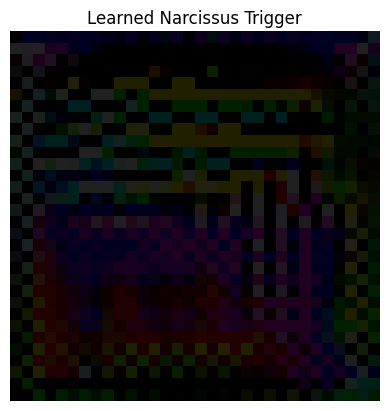

In [22]:
from pickle import TRUE
%cd /content/Narcissus

import sys, os
sys.path.insert(0, os.getcwd())

import os
import copy
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.optim import Optimizer
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader, TensorDataset
import tqdm

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from models import ResNet18_201, ResNet18
from util import get_labels, concoct_dataset, apply_noise_patch, poison_image, poison_image_label, AverageMeter

# reproducibility
random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

# select GPU
torch.cuda.set_device(0)
device = 'cuda'

# Paths & hyperparameters
dataset_path        = './data/'           # CIFAR-10 + tiny-imagenet under this folder
lab                 = 2                   # target class index
noise_size          = 32                  # width/height of trigger
l_inf_r             = 16/255              # ℓ∞ bound
surrogate_epochs    = 50                  # POOD pre-train epochs
generating_lr_warmup= 0.1                 # LR for poison warm-up
warmup_round        = 5                   # poison warm-up epochs
generating_lr_tri   = 0.01                # LR for trigger generation
gen_round           = 1000                # trigger iters
train_batch_size    = 350                 # batchsize
patch_mode          = 'add'               # how to add noise

# ------------------------------------------------------------------------------
# 1) Prepare datasets & loaders
# ------------------------------------------------------------------------------

# transforms
transform_surrogate_train = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

# datasets
ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True,  download=True, transform=transform_train)
ori_test  = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True, transform=transform_test)
outter_trainset = torchvision.datasets.ImageFolder(root=os.path.join(dataset_path,'tiny-imagenet-200/train/'),
                                                   transform=transform_surrogate_train)

# get labels arrays
train_label = get_labels(ori_train)
test_label  = get_labels(ori_test)

# subset target-class samples
train_target_list = list(np.where(np.array(train_label)==lab)[0])
train_target      = Subset(ori_train, train_target_list)

# concoct POOD+target dataset
concoct_train_dataset = concoct_dataset(train_target, outter_trainset)

# loaders
surrogate_loader   = DataLoader(concoct_train_dataset, batch_size=train_batch_size, shuffle=True,  num_workers=16)
poi_warm_up_loader = DataLoader(train_target,            batch_size=train_batch_size, shuffle=True,  num_workers=16)
trigger_gen_loader = DataLoader(train_target,            batch_size=train_batch_size, shuffle=True,  num_workers=16)

# ------------------------------------------------------------------------------
# 2) Train surrogate model on POOD + fine-tune
# ------------------------------------------------------------------------------

surrogate_model = ResNet18_201().to(device)
criterion       = nn.CrossEntropyLoss()
surrogate_opt   = optim.SGD(surrogate_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
surrogate_sched = optim.lr_scheduler.CosineAnnealingLR(surrogate_opt, T_max=surrogate_epochs)

print('*** Training surrogate model (POOD pre-train + fine-tune) ***')
for epoch in range(surrogate_epochs):
    surrogate_model.train()
    losses = []
    for imgs, lbls in surrogate_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        surrogate_opt.zero_grad()
        out = surrogate_model(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        surrogate_opt.step()
        losses.append(loss.item())
    surrogate_sched.step()
    print(f'Epoch {epoch+1}/{surrogate_epochs} — Loss: {np.mean(losses):.4f}')

# save surrogate
os.makedirs('./checkpoint', exist_ok=True)
torch.save(surrogate_model.state_dict(), f'./checkpoint/surrogate_pretrain_{surrogate_epochs}.pth')

# ------------------------------------------------------------------------------
# 3) Poison warm-up
# ------------------------------------------------------------------------------

poi_model = ResNet18_201().to(device)
poi_model.load_state_dict(surrogate_model.state_dict())
poi_opt   = optim.RAdam(poi_model.parameters(), lr=generating_lr_warmup)

print('\n*** Poison warm-up ***')
for epoch in range(warmup_round):
    poi_model.train()
    losses = []
    for imgs, lbls in poi_warm_up_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        poi_opt.zero_grad()
        out = poi_model(imgs)
        loss = criterion(out, lbls)
        loss.backward(retain_graph=True)
        poi_opt.step()
        losses.append(loss.item())
    print(f'Epoch {epoch+1}/{warmup_round} — Warm-up Loss: {np.mean(losses):.4e}')

# ------------------------------------------------------------------------------
# 4) Trigger generation
# ------------------------------------------------------------------------------

print('\n*** Trigger generation ***')
noise = torch.zeros((1,3,noise_size,noise_size), device=device, requires_grad=True)
batch_opt = optim.RAdam([noise], lr=generating_lr_tri)

for it in tqdm.notebook.tqdm(range(gen_round)):
    all_losses = []
    for imgs, lbls in trigger_gen_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        new_imgs   = imgs.clone()
        delta      = torch.clamp(noise, -l_inf_r*2, l_inf_r*2)
        new_imgs   = torch.clamp(apply_noise_patch(delta, new_imgs, mode=patch_mode), -1,1)
        logits     = poi_model(new_imgs)
        loss       = criterion(logits, lbls).mean()
        batch_opt.zero_grad()
        loss.backward(retain_graph=True)
        batch_opt.step()
        all_losses.append(loss.item())
    avg_grad = noise.grad.abs().sum().item()
    if avg_grad == 0:
        break
    if (it+1)%100 == 0:
        print(f'Iter {it+1}/{gen_round} — Loss: {np.mean(all_losses):.4f}, Grad sum: {avg_grad:.4e}')

# finalize trigger
best_noise = torch.clamp(noise.detach(), -l_inf_r*2, l_inf_r*2).cpu()
plt.imshow(np.transpose(best_noise[0],(1,2,0)))
plt.title('Learned Narcissus Trigger')
plt.axis('off')
plt.show()

# save trigger
ts = time.strftime("%m-%d-%H_%M_%S", time.localtime())
np.save(f'./checkpoint/best_noise_{ts}.npy', best_noise)

# ------------------------------------------------------------------------------
# 5) (Optional) Test attack effect via training a new model
# ------------------------------------------------------------------------------

# you can append your testing/training loop here as needed...


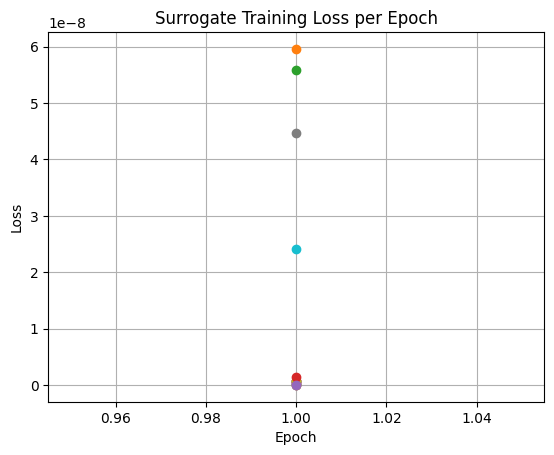

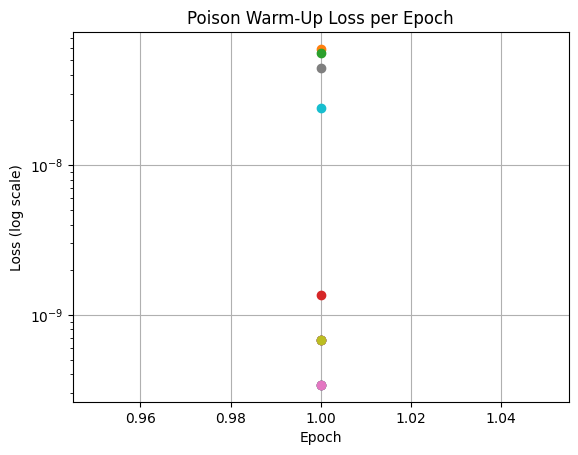

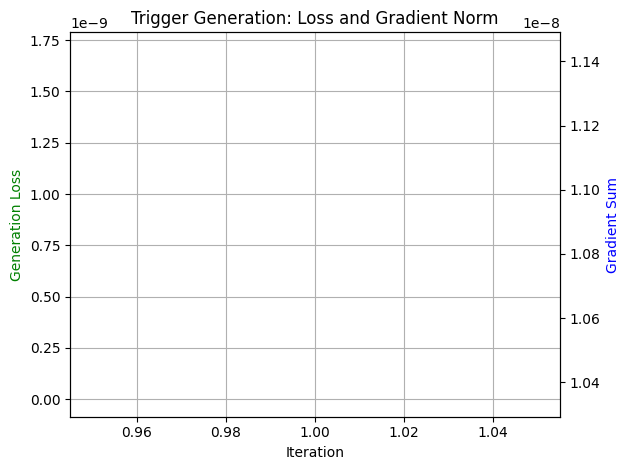

In [50]:
surrogate_losses = []
warmup_losses    = []
gen_losses       = []
grad_sums        = []

# Surrogate
surrogate_losses.append(losses)

# Warm-up
warmup_losses.append(losses)

# Generation
gen_losses.append(all_losses)
grad_sums .append(noise.grad.abs().sum().item())

plt.figure()
plt.plot(range(1, len(surrogate_losses)+1), surrogate_losses, marker='o')
plt.title('Surrogate Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot warm-up loss per epoch
plt.figure()
plt.plot(range(1, len(warmup_losses)+1), warmup_losses, marker='o')
plt.title('Poison Warm-Up Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.grid(True)
plt.show()

# Plot trigger generation loss and gradient sum
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(1, len(gen_losses)+1), gen_losses, 'g-', label='Gen Loss')
ax2.plot(range(1, len(grad_sums)+1), grad_sums, 'b--', label='Grad Sum')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Generation Loss', color='g')
ax2.set_ylabel('Gradient Sum', color='b')
plt.title('Trigger Generation: Loss and Gradient Norm')
ax1.grid(True)
fig.tight_layout()
plt.show()

In [49]:
print(losses)

[3.40597938741638e-10, 5.9604641222676946e-08, 6.81195877483276e-10, 6.81195877483276e-10, 6.81195877483276e-10, 3.40597938741638e-10, 3.40597938741638e-10, 4.46183285873758e-08, 6.81195877483276e-10, 2.4182453373100543e-08, 0.0, 0.0, 5.585806306385166e-08, 1.362391754966552e-09, 0.0]


In [23]:
%cd ..
%cd /content/Telltale/
!mkdir -p temps
!python telltale_defense.py \
  --data_root    /content/Narcissus/data \
  --checkpoints  /content/Narcissus/checkpoint \
  --temps        ./temps/ \
  --device       cuda \
  --dataset      cifar10 \
  --input_height 32 \
  --input_width  32 \
  --input_channel 3 \
  --num_classes  10 \
  --batchsize    200 \
  --lr_C         1e-2 \
  --schedulerC_milestones [80,120] \
  --schedulerC_lambda    0.1 \
  --n_iters      120 \
  --lambda_div   1 \
  --lambda_norm  100 \
  --num_workers  4 \
  --target_label 2 \
  --p_attack     0.0005 \
  --mask_density 1.0 \
  --EPSILON      1e-7 \
  --random_rotation 10 \
  --random_crop     5 \
  --gpu           0


/content
/content/Telltale
The truncated loss trajectory data has been successfully loaded.
(30, 438)
(30, 49562)
(30, 50000)
  The loss curve has been saved at './figure/loss_curve.png'.
  An already existing weight for autoencoder will be loaded.
  t-SNE visualization...
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/content/Telltale/telltale_defense.py:108: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_samples_tsne[:, 0], all_samples_tsne[:, 1], c=colors[labels], cmap='coolwarm', alpha=0.5)
  The t-SNE visualization has been saved at './figure/t_sne.png'.
  Clustering using DBSCAN...

***** Detection Accuracy & FPR *****
Det.Acc: 96.119% 421/438
FPR: 0.000% 0/49562


In [27]:

%cd /content/Narcissus
import glob
print(sorted(glob.glob('data/cifar-10-batches-py/*'))[:5])


/content/Narcissus
['data/cifar-10-batches-py/batches.meta', 'data/cifar-10-batches-py/data_batch_1', 'data/cifar-10-batches-py/data_batch_2', 'data/cifar-10-batches-py/data_batch_3', 'data/cifar-10-batches-py/data_batch_4']


In [40]:
!git clone https://github.com/VinAIResearch/Warping-based_Backdoor_Attack-release.git
%cd Warping-based_Backdoor_Attack-release


Cloning into 'Warping-based_Backdoor_Attack-release'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 170 (delta 39), reused 35 (delta 35), pack-reused 118 (from 2)
Receiving objects: 100% (170/170), 673.63 KiB | 1.48 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/Warping-based_Backdoor_Attack-release


In [42]:
!pip install kornia


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 102.7 MB/s eta 0:00:00


In [47]:
!python train.py \
  --data_root             ./data/ \
  --checkpoints           ./checkpoint/ \
  --temps                 ./temps/ \
  --device                cuda \
  --dataset               cifar10 \
  --attack_mode           all2one \
  --bs                    128 \
  --lr_C                  0.1 \
  --schedulerC_milestones "[80,120]" \
  --schedulerC_lambda     0.1 \
  --n_iters               120 \
  --num_workers           4 \
  --target_label          2 \
  --pc                    0.01 \
  --cross_ratio           0 \
  --random_rotation       10 \
  --random_crop           5 \
  --s                     1.0 \
  --k                     4 \
  --grid-rescale          1



2025-06-21 13:02:13.194383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750510933.214452  163297 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750510933.220514  163297 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-21 13:02:13.240300: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Train from scratch!!!
/content/Warping-based_Backdoor_Attack-release/train.py:346: UserWarning: `nn.functional.upsamp

In [ ]:
python telltale_defense.py \
  --data_root    ./data/ \
  --checkpoints  ./checkpoint/ \
  --temps        ./temps/ \
  --device       cuda \
  --dataset      cifar10 \
  --input_height 32 \
  --input_width  32 \
  --input_channel 3 \
  --num_classes  10 \
  --batchsize    200 \
  --lr_C         1e-2 \
  --schedulerC_milestones [80,120] \
  --schedulerC_lambda    0.1 \
  --n_iters      120 \
  --lambda_div   1 \
  --lambda_norm  100 \
  --num_workers  4 \
  --target_label 2 \
  --p_attack     0.01 \
  --mask_density 1.0 \
  --EPSILON      1e-7 \
  --random_rotation 10 \
  --random_crop     5 \
  --gpu           0
